In [25]:
# Thêm autoreload vào để tự động reload lại module nếu có thay đổi code trong module
%load_ext autoreload
%autoreload 2

import mediapipe as mp
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import warnings

# Thêm đường dẫn dẫn đến thư mục cha
sys.path.append(os.path.abspath(".."))
warnings.filterwarnings("ignore")

# Drawing helpers
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Extract data

In [26]:
def draw_landmarks(mp_drawing, mp_pose, image : cv2, pose_landmarks : np.array):
    """
    Vẽ landmarks lên ảnh
    """
    mp_drawing.draw_landmarks(
        image,
        pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing.DrawingSpec(
            color=(255, 0, 0),  # Màu sắc của các landmark
            thickness=5,  # Độ dày của các đường nối landmark
            circle_radius=5,  # Bán kính của các điểm landmark
        ),
        connection_drawing_spec=mp_drawing.DrawingSpec(
            color=(0, 255, 0),  # Màu sắc của các đường nối
            thickness=5,  # Độ dày của các đường nối
        ),
    )

In [27]:
def extract_key_points_from_image(
    image_path: str, label: str, output_file: str, is_draw_landmarks=False
):
    # Khởi tạo MediaPipe Pose
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(
        static_image_mode=True, model_complexity=1, smooth_landmarks=True
    )

    image = cv2.imread(image_path)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Phát hiện pose
    results = pose.process(image_rgb)

    if results.pose_landmarks:

        if is_draw_landmarks:
            draw_landmarks(mp_drawing, mp_pose, image, results.pose_landmarks)
            last_dot_index = image_path.rfind(".")
            image_path_output = image_path[:last_dot_index] + "_landmarks" + image_path[last_dot_index:]
            cv2.imwrite(image_path_output, image) # Lưu ảnh đã vẽ landmark

        # Lưu lại toạ độ các key points sau khi dịch chuyển vào csv
        columns_name = ["label"]
        columns_value = [label]
        for id, landmark in enumerate(results.pose_landmarks.landmark):
            land_mark_name = mp_pose.PoseLandmark(id).name.lower()
            
            columns_name += [
                f"{ land_mark_name }_x",
                f"{ land_mark_name }_y",
                f"{ land_mark_name }_z",
            ]

            # landmark.x, landmark.y là các giá trị trước khi dịch chuyển gốc toạ độ vào giữa bức hình
            # Do đó khi đưa gốc toạ độ về giữa bức hình thì phải trừ chúng cho 0.5
            columns_value += [
                landmark.x - 0.5,
                landmark.y - 0.5,
                landmark.z,
            ]

        df_key_points = pd.DataFrame([columns_value], columns=columns_name)

        with open(output_file, "a") as f:
            # header=f.tell()==0 sẽ ghi tiêu đề nếu file trống
            df_key_points.to_csv(f, header=f.tell() == 0, index=False)
        
    else:
        print(f"Cannot detect pose in image {image_path}")

    pose.close()

In [28]:
def auto_label_from_folder(folder_path: str, output_file: str, label: str = None):
    """
    Tự động gán nhãn cho các ảnh trong thư mục
    """ 
    # Traverse the folder and process each file
    for root, _, files in os.walk(folder_path):
        print(f"Processing folder {root}")
        for file in files:
            file_path = os.path.join(root, file)
            label = label if label else os.path.basename(root)
            extract_key_points_from_image(file_path, label, output_file)

In [29]:
auto_label_from_folder("../../data_images/1_lie_on_clean", "../../data/data_raw.csv")

auto_label_from_folder("../../data_images/2_side_clean", "../../data/data_raw.csv")

auto_label_from_folder("../../data_images/3_procumbent_clean", "../../data/data_raw.csv")

Processing folder ../../data_images/1_lie_on_clean
Cannot detect pose in image ../../data_images/1_lie_on_clean\155.jpg
Cannot detect pose in image ../../data_images/1_lie_on_clean\57.jpg
Processing folder ../../data_images/2_side_clean
Cannot detect pose in image ../../data_images/2_side_clean\132.jpg
Cannot detect pose in image ../../data_images/2_side_clean\52.jpg
Cannot detect pose in image ../../data_images/2_side_clean\664.jpg
Cannot detect pose in image ../../data_images/2_side_clean\99.jpg
Processing folder ../../data_images/3_procumbent_clean


In [30]:
df = pd.read_csv("../../data/data_raw.csv")

<Axes: xlabel='label', ylabel='count'>

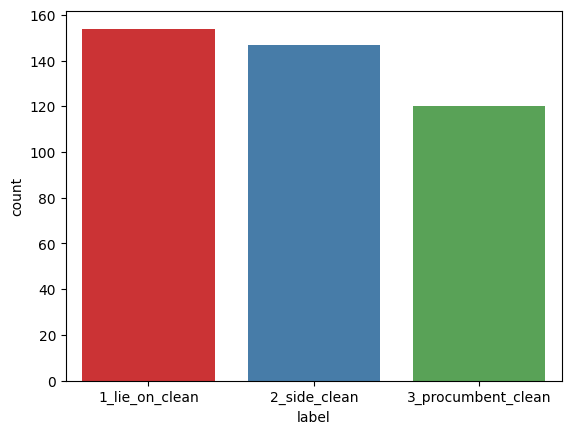

In [31]:
sns.countplot(data=df, x="label", palette="Set1")